# $\color{purple}{\text{Understanding Missing Data and How to Deal with It (Part 6)}}$

## $\color{purple}{\text{Missing Data in the Age of Machine Learning and Artifical Neural Network}}$

### $\color{purple}{\text{Colab Environmental Setup}}$

### $\color{purple}{\text{Libraries for this lesson}}$

In [383]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from autoimpute.imputations import MiceImputer
from autoimpute.imputations import SingleImputer
from matplotlib.patches import Rectangle
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from helpers import ImputationDisplayer, stat_comparison

### $\color{purple}{\text{Neural Network Imputers}}$

#### $\color{purple}{\text{Denoising Autoencoders}}$

* The missing data (or deviation from an imputed value) is treated as noise.
* Denoising autoencoders are neural networks trained on the same input and output.
* Theory is that the output is trained so that the output is the input with noise removed.
* To work properly, data should be normalized during the imputation.

`scaler` uses `sklearn`'s `StandardScaler`


In [170]:
df = pd.read_csv('data/full_set.csv')
dmar_df = pd.read_csv('data/double_mar_set.csv')
ImputationDisplayer(dmar_df)
scaler = StandardScaler()
scaler.fit(dmar_df)
sdmar_df = pd.DataFrame(scaler.transform(dmar_df), columns=dmar_df.columns)

In [190]:
def restore_df(scaler, x):
    """
    Inverse the scaler and created a dataframe
    """
    return pd.DataFrame(scaler.inverse_transform(x), columns = dmar_df.columns)

The basic autoencoder proposed by [Gondara and Wang](https://arxiv.org/abs/1705.02737)
* Deep neural network with 5 hidden layers with a dropout layer
* $\Theta$ is a hyperparameter governing the expansion and contraction of the layer
* $\Theta=7$ is suggested by best practice.
* In the first 3 hidden layers, each layer expands by $\Theta$ and contracts by $\Theta$ in the last 2 hidden layers.

#### Step 1 Impute the data set using univariate imputation
The recommendation is that mean or median imputation of numeric data and mode imputation of categorical data

In [178]:
univariate_imputed = SingleImputer('median').fit_transform(sdmar_df)

#### Step 2 Split data into training and test sets
This is only necessary if you are building a model that accepts future data (open configuration). If the data set is closed (i.e. you don't expect any new data) then you can set the test_size to 0

In [179]:
theta=7
# Divide into training and test sets
training, test=train_test_split(univariate_imputed, test_size = 0.3)

#### Step 3 Build, Compile and Train a Deep Neural Network Model
* theta and activation function are hyperparameters

See `tensorflow` and `keras` documentation for further detail

In [180]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5+theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+2*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+3*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+2*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5)
])

In [181]:
# Compile the model
model.compile(optimizer='adam',  loss='mse')

In [182]:
history = model.fit(training, training, epochs=50, verbose=False)

You can visualize the progress of the loss

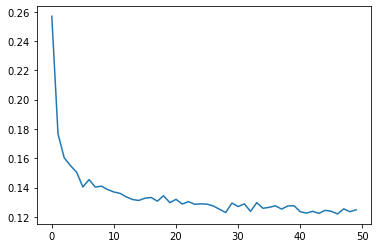

In [183]:
plt.plot(history.history['loss'])

#### Step 4 Make Prediction based on initial imputation.
We replace the missing values with the predicted value. We also convert back to `pandas` `DataFrame`

In [184]:
predicted = pd.DataFrame(model.predict(univariate_imputed), columns = dmar_df.columns)

In [191]:
# Don't forget to rescale the data after filling in missing data
imputed=restore_df(scaler, sdmar_df.combine_first(predicted))

In [192]:
dmar_df.displayer(imputed, 10)

,feature a,feature b,feature c,feature d,uncorrelated
0,2.777245,2.102816,-1.552282,8.772158,0.360789
1,2.447336,2.223169,-0.645673,8.815675,0.393466
2,1.936893,2.182897,-2.474526,8.549983,0.891191
3,2.484183,1.618856,-1.404809,7.360904,0.156937
4,2.089727,2.698967,-1.464007,7.786100,0.046178
5,3.369940,2.842243,-0.716772,8.767852,0.342830
6,0.764542,1.532282,-3.850084,7.992571,0.678203
7,3.539507,2.120999,0.181066,7.158813,0.942345
8,2.312462,1.816557,-1.325628,8.144401,0.460626
9,0.445575,0.827475,-4.705004,8.161819,0.014623


In [193]:
stat_comparison(df, imputed, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.411082,2.222218,0.188864,7.833155
median,2.420924,2.323133,0.097791,4.039402
stdev,1.279456,1.132181,0.147275,11.510744


In [194]:
stat_comparison(df, imputed, 'feature b')

,Original,With Missing Data,difference,percentage
mean,2.167609,2.061645,0.105964,4.888531
median,2.169837,2.090655,0.079183,3.649238
stdev,0.752618,0.668361,0.084257,11.195223


#### $\color{purple}{\text{Improved Feedback Denoising Autoencoders}}$

My own enhancement to the denoising autoencoder see [here](https://arxiv.org/abs/2002.08338)

The algorithm was designed for closed data sets. This example shows one enhancement to the denoising autoencoder (DAE), the iterative refinement of the imputed values. It starts similarly by univariate imputation as **step 1**.

In [195]:
univariate_imputation = SingleImputer('median').fit_transform(sdmar_df)

#### Step 2 Build and Compile Deep Neural Network Model
We use the same architecture as the DAE

In [196]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5+theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+2*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+3*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+2*theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5+theta, activation=tf.nn.tanh),
  tf.keras.layers.Dense(5)
])

In [197]:
# Compile the model
model.compile(optimizer='adam',loss='mse')

#### Step 3 Initial Fit
Fewer epochs than standard DAE

In [198]:
history = [model.fit(univariate_imputation, univariate_imputation, epochs=10,verbose=False)]

#### Step 4 Iteration


In [199]:
predicted = pd.DataFrame(model.predict(univariate_imputation), columns = dmar_df.columns)
iterated_imputation=sdmar_df.combine_first(predicted)
history.append(model.fit(iterated_imputation, iterated_imputation, epochs=2, verbose=False))

#### Repeat the Iteration a Prescribed Number of Times

In [200]:
for _ in range(0, 19):
    predicted = pd.DataFrame(model.predict(iterated_imputation), columns = dmar_df.columns)
    iterated_imputation=sdmar_df.combine_first(predicted)
    history.append(model.fit(iterated_imputation, iterated_imputation, epochs=2, verbose=False))

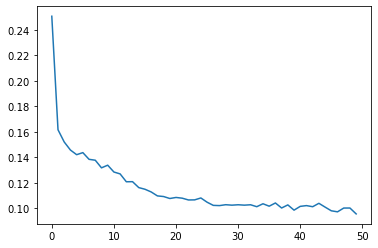

In [209]:
# Since we collected history in several batches, concatenate them so we can see a plot
losses = sum([each.history['loss'] for each in history],[])
plt.plot(losses)

#### Plug the final prediction into the missing values and rescale the result

In [214]:
predicted = pd.DataFrame(model.predict(iterated_imputation), columns = dmar_df.columns)
imputed=restore_df(scaler, sdmar_df.combine_first(predicted))

In [215]:
dmar_df.displayer(imputed, 10)

,feature a,feature b,feature c,feature d,uncorrelated
0,2.777245,2.229025,-1.552282,8.772158,0.360789
1,2.717194,2.223169,-0.645673,8.815675,0.393466
2,1.936893,2.182897,-2.474526,8.549983,0.891191
3,2.484183,1.618856,-1.404809,7.360904,0.156937
4,2.089727,2.698967,-1.464007,7.786100,0.046178
5,3.369940,2.842243,-0.716772,8.767852,0.342830
6,0.764542,1.532282,-3.850084,7.992571,0.678203
7,3.539507,2.120999,0.181066,7.158813,0.942345
8,2.737183,1.816557,-1.325628,8.144401,0.460626
9,0.445575,0.827475,-4.705004,8.161819,0.014623


In [213]:
stat_comparison(df, imputed, 'feature a')

,Original,With Missing Data,difference,percentage
mean,2.411082,2.277080,0.134003,5.557778
median,2.420924,2.441958,0.021034,0.868836
stdev,1.279456,1.150020,0.129436,10.116457


## $\color{purple}{\text{How Imputation Fits Into Your Machine Learning Models}}$

* Typical ML Workflow
  * Train
  * Test
  * Use
* Save Your Pipeline
* You can include an imputer in your pipeline

* We demonstrate this using `sklearn`'s pipeline. But this is meant to describe abstractly what you should do

Same data set is taken from the [Wine Quality Dataset at UCI](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

This demonstrates a typical pipeline. The final column `quality` is the predicted value. The `features` variable contains all the other column names

In [219]:
training=pd.read_csv('data/original_wine_training.csv')
test=pd.read_csv('data/original_wine_test.csv')

In [220]:
training

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,8.0,0.500,0.39,2.60,0.082,12.0,46.0,0.99850,3.43,0.62,10.7,red,6
1,6.6,0.280,0.28,8.50,0.052,55.0,211.0,0.99620,3.09,0.55,8.9,white,6
2,7.0,0.190,0.23,5.70,0.123,27.0,104.0,0.99540,3.04,0.54,9.4,white,6
3,7.4,0.200,0.37,16.95,0.048,43.0,190.0,0.99950,3.03,0.42,9.2,white,6
4,7.8,0.280,0.34,1.60,0.028,32.0,118.0,0.99010,3.00,0.38,12.1,white,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,9.8,0.300,0.39,1.70,0.062,3.0,9.0,0.99480,3.14,0.57,11.5,red,7
4996,8.3,0.845,0.01,2.20,0.070,5.0,14.0,0.99670,3.32,0.58,11.0,red,4
4997,7.1,0.360,0.28,2.40,0.036,35.0,115.0,0.98936,3.19,0.44,13.5,white,7
4998,6.6,0.240,0.27,15.80,0.035,46.0,188.0,0.99820,3.24,0.51,9.2,white,5


In [221]:
features = list(training.columns[0:-1])

We build the pipeline by one-hot encoding the `type` column which is categorical, then scale it, then apply random forest regressor

In [222]:
pipeline = make_pipeline(
        ColumnTransformer([("type", OneHotEncoder(),["type"])],remainder='passthrough'),
    StandardScaler(), RandomForestRegressor())

In [223]:
pipeline.fit(training[features], training['quality'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('type', OneHotEncoder(),
                                                  ['type'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())])

In [225]:
pipeline.score(test[features], test['quality'])

0.5432417180317055

In [64]:
pipeline.predict(training[features])

array([5.89, 5.49, 5.93, ..., 6.91, 5.16, 6.75])

### Imputer in the Pipeline

This is meant to demonstrate workflow and `autoimpute` is used as an example.

One drawback is that `autoimpute` imputers require a `pandas` `DataFrame` as an input so custom transformers need to be used.


In [434]:
pandas_hack = FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['type_r', 'type_w']+features[0:-1]))
pandas_hack_full = FunctionTransformer(lambda x: pd.DataFrame(x, columns = ['type_r', 'type_w']+features))

We can insert the imputer into the pipeline

In [227]:
pipeline = make_pipeline(ColumnTransformer([
   ("type", OneHotEncoder(),['type'])],remainder='passthrough'), pandas_hack, SingleImputer(strategy='least squares'),
                         StandardScaler(), RandomForestRegressor())

In [318]:
wine_training=pd.read_csv('data/wine_training.csv')
pipeline.fit(wine_missing[features], wine_training['quality'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('type', OneHotEncoder(),
                                                  ['type'])])),
                ('standardscaler', StandardScaler()),
                ('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f6d89265e50>)),
                ('miceimputer', MiceImputer(k=5, strategy='stochastic'))])

In [319]:
wine_test=pd.read_csv('data/wine_test.csv')
pipeline.score(wine_test[features], wine_test['quality'])

AttributeError: 'MiceImputer' object has no attribute 'score'

In [320]:
wine_future=pd.read_csv('data/wine_future.csv')
pipeline.predict(wine_future[features].iloc[0:10])

AttributeError: 'MiceImputer' object has no attribute 'predict'

Neural Network Based Autoencoder Imputation

## How does Multiple Imputation fit in?

### Approach 1: Augment Data with Multiple Copies

Augmentation teachs the model that the imputed values are "fuzzy" by providing different values.

We create the same pipeline except we have a MiceImputer at the end.
The resultant `dfs` are 5 copies of our dataframe with 5 separate imputations

In [321]:
pipeline = make_pipeline(ColumnTransformer([
   ("type", OneHotEncoder(),['type'])],remainder='passthrough'),
                         StandardScaler(),pandas_hack, MiceImputer(k=5, strategy='stochastic'))
dfs = [each[1] for each in pipeline.fit_transform(wine_training[features])]
len(dfs)

5

We augment the training set by concatenating the 5 different data frame. Equivalently, we could rotate each epoch with different imputations.

In [322]:
augmented_training = pd.concat(dfs)

Build out model as a classification problem. Bear in mind this is just for demonstration purposes, we model is not a particularly good estimator

In [374]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [375]:
quality = pd.concat([wine_training.quality,
                     wine_training.quality,
                     wine_training.quality,
                     wine_training.quality,
                     wine_training.quality])

In [376]:
model.fit(augmented_training, quality, epochs=10, verbose=False)

Since test set is used to evaluate when the model may hit overtraining, it is not necessary to multiply impute the tests. But you may.

In [377]:
test_dfs = [each[1] for each in pipeline.transform(wine_test[features])]
test1 = test_dfs[0] # Variation one, just take one imputation
test2 = pd.concat(test_dfs) # Variation two augment in the same way
quality1 = wine_test.quality
quality2 = pd.concat([quality1, quality1, quality1, quality1, quality1])

In [378]:
model.evaluate(test1, quality1)

32/32 [==============================] - 0s 1ms/step - loss: 1.0336 - accuracy: 0.5420


[1.0335584878921509, 0.5419999957084656]

In [379]:
model.evaluate(test2, quality2)

157/157 [==============================] - 0s 1ms/step - loss: 1.0395 - accuracy: 0.5394


[1.0394865274429321, 0.5393999814987183]

#### What about future values?
Same options:
 * take one imputation
 * run all imputations through the model and us an ensemble technique to combine (e.g., majority voting)

In [380]:
future_dfs = [each[1].iloc[[0]] for each in pipeline.transform(wine_future[features])]
future1 = future_dfs[0] # Variation one, just take one imputation
future2 = pd.concat(future_dfs) # Variation two augment in the same way

In [384]:
# Variation 1: Pick First Imputed
np.argmax(model.predict(future1))

7

In [385]:
# Variation 2: Aggregate all Imputed
np.argmax(model.predict(future2).sum(axis=0))

7

### Approach 2: Combine Multiple Models

In [429]:
models = [tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
) for _ in range(0,5)]
for model in models:
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Each model is trained on a different imputation model. Each model should be tested under each imputation model

In [430]:
for model, training in zip(models, dfs):
    model.fit(training, wine_training.quality, epochs=10, verbose=False)

In [431]:
for model, test in zip(models, test_dfs):
    print (model.evaluate(test, wine_test.quality, verbose=False))

[1.0722581148147583, 0.5299999713897705]
[1.072456955909729, 0.5320000052452087]
[1.0794332027435303, 0.5199999809265137]
[1.0710456371307373, 0.5320000052452087]
[1.0745283365249634, 0.5189999938011169]


In [447]:
# np vstack turns the list of arrays into an array of arrays
predictions = np.vstack([model.predict(future) for model, future in zip(models, future_dfs)])

In [448]:
# Aggregate predictions
np.argmax(predictions.sum(axis=0))

7

### Worth Mentioning: Use Single Imputation with Bagging

Short for bootstrap and aggregation

Rather than multiple imputation, single imputations are performed from resampled datasets (bootstrapping)


In [449]:
pipeline = make_pipeline(ColumnTransformer([
   ("type", OneHotEncoder(),['type'])],remainder='passthrough'),
                         StandardScaler(),pandas_hack_full, MiceImputer(k=1, strategy='stochastic'))
bagged_dfs = [next(pipeline.fit_transform(wine_training.sample(frac=1, replace=True)))[1] for _ in range(0,5)]


In [450]:
models = [tf.keras.models.Sequential([
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(20, activation=tf.nn.tanh),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)]
) for _ in range(0,5)]
for model in models:
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [451]:
for model, training in zip(models, dfs):
    model.fit(training, wine_training.quality, epochs=10, verbose=False)

In [452]:
predictions = np.vstack([model.predict(future) for model, future in zip(models, future_dfs)])
# Aggregate predictions
np.argmax(predictions.sum(axis=0))

7

### Worth Mentioning: Use missingness as a feature

The idea is that you are giving information to the model as to which values are imputed.

In [453]:
pipeline = make_pipeline(ColumnTransformer([
   ("type", OneHotEncoder(),['type'])],remainder='passthrough'),
                         StandardScaler(),pandas_hack, SingleImputer(strategy='stochastic'))
processed=pipeline.fit_transform(wine_test[features])

We add a feature for each feature that has missing values indicating whether the corresponding row entry is missing that feature

In [454]:
for each in features:
    processed[f'{each}_missing']=wine_test[each].isnull().astype(int)

In [455]:
processed

,type_r,type_w,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,...,citric acid_missing,residual sugar_missing,chlorides_missing,free sulfur dioxide_missing,total sulfur dioxide_missing,density_missing,pH_missing,sulphates_missing,alcohol_missing,type_missing
0,1.718304,-1.718304,0.663555,1.448871,-0.583833,-0.836745,0.806965,-0.307492,-0.190794,0.505750,...,0,1,0,0,0,0,0,0,0,0
1,-0.581969,0.581969,-0.867392,0.549951,-1.876388,-0.811454,-0.619186,0.348643,0.142705,-1.665259,...,1,0,0,0,0,0,0,0,0,0
2,-0.581969,0.581969,0.905283,-0.860624,2.978233,-0.172977,-0.359886,-0.443001,0.707848,-0.773533,...,0,0,0,1,1,0,0,0,0,0
3,-0.581969,0.581969,1.388740,-0.456462,0.238182,1.179730,-0.846074,-0.585088,0.879915,0.697814,...,0,0,0,0,0,0,0,0,0,0
4,-0.581969,0.581969,-0.464511,-1.033836,-0.035823,-0.898027,-0.068124,-0.913156,-0.752478,-1.270842,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.581969,0.581969,-0.706239,-1.033836,0.101179,-0.227085,-0.489536,0.298171,0.019837,-0.972457,...,0,0,0,0,0,0,0,0,0,0
996,-0.581969,0.581969,-0.037249,-0.283250,0.786192,-0.501291,-0.327473,0.701946,1.704888,-0.041400,...,0,1,0,0,0,1,0,0,0,0
997,-0.581969,0.581969,-0.786816,-0.860624,0.169681,0.032635,-0.878487,-0.509380,-0.717373,-1.555508,...,0,0,0,0,0,0,0,0,0,0
998,1.718304,-1.718304,-1.431425,0.409598,-0.241327,-0.703237,-0.593481,-0.408436,-1.324124,0.018731,...,0,0,1,0,1,0,0,0,1,0


## Conclusion

* The bulk of work with models dealing with missing data uses decision tree derivative models
* Neural Networks can be used for imputation
* Several strategies for integrating imputation into model building pipelines
  * Imputer should be a processing step (important that models are saveable)
  * Multiple Imputation can use data augmentation or multiple models
  * Bagging can be applied to single imputation performed multiply
  * Missingness (or imputed) can be added as a flag.